In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

from load_wastewater_data import load_systems_data
from plotting_tools import *

# Update rcParams to set the default font to Times New Roman
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"
resolution = "3_min_resolution" 

In [3]:
plot_path = f"../plots/wastewater_model/rain_decay_correlations"
os.makedirs(os.path.join(plot_path), exist_ok=True)

Load data

In [4]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"
df_prevalence = pd.read_csv(os.path.join(infection_model_output_path, "console_output_summarized.csv"))

In [5]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [6]:
def get_crosscorr_for_one_station(df_combined, sampling_location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.sampling_point==sampling_location, :].sort_values("hours")
    return [crosscorr(df_combined_sub["COVID_copies/l"], df_combined_sub["I_total"], lag) for lag in lags_in_hours]

In [7]:
df_ww_no_rain = load_systems_data(experiment_series, resolution, "KeinRegen", "no_decay", file_type="concentrations")
df_ww_no_rain["hours"] = df_ww_no_rain["minutes"]/60
df_ww_no_rain = df_ww_no_rain[[int(x)==x for x in df_ww_no_rain.hours]]

df_ww_gentle_rain = load_systems_data(experiment_series, resolution, "Nieselregen", "no_decay", file_type="concentrations")
df_ww_gentle_rain["hours"] = df_ww_gentle_rain["minutes"]/60
df_ww_gentle_rain = df_ww_gentle_rain[[int(x)==x for x in df_ww_gentle_rain.hours]]

df_ww_mod_rain = load_systems_data(experiment_series, resolution, "MittelstarkerRegen", "no_decay", file_type="concentrations")
df_ww_mod_rain["hours"] = df_ww_mod_rain["minutes"]/60
df_ww_mod_rain = df_ww_mod_rain[[int(x)==x for x in df_ww_mod_rain.hours]]

df_ww_mod_rain_linear_decay = load_systems_data(experiment_series, resolution, "MittelstarkerRegen", "linear_decay_0_001", file_type="concentrations")
df_ww_mod_rain_linear_decay["hours"] = df_ww_mod_rain_linear_decay["time_in_days"]*24
df_ww_mod_rain_linear_decay = df_ww_mod_rain_linear_decay[[int(x)==x for x in df_ww_mod_rain_linear_decay.hours]] 

df_ww_mod_rain_constant_decay = load_systems_data(experiment_series, resolution, "MittelstarkerRegen", "constant_decay_0_1", file_type="concentrations")
df_ww_mod_rain_constant_decay["hours"] = df_ww_mod_rain_constant_decay["time_in_days"]*24
df_ww_mod_rain_constant_decay = df_ww_mod_rain_constant_decay[[int(x)==x for x in df_ww_mod_rain_constant_decay.hours]] 


In [8]:
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

def get_crosscor_for_all_stations(df_ww):
    results = []
    for sampling_location in ["7", "8", "12", "14", "16"]:
        
        loc_corr = []
        for sim in df_prevalence['memilio_id'].unique():
            curr_sim_ww = df_ww.loc[df_ww['memilio_id'] == sim]
            curr_sim_prev = df_prevalence.loc[df_prevalence['memilio_id'] == sim]
            curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="hours", right_on="time", how="left")
            loc_corr.append(get_crosscorr_for_one_station(curr_combined, str(sampling_location), range(-max_lag, max_lag+1, 1)))
        
        df_corr = pd.DataFrame(loc_corr)
        results.append(df_corr.mean(axis = 0))
        print(sampling_location)
    return results

max_lag = 45


In [9]:
df_ww_gentle_rain_norm = pd.read_csv("../data/PMMoV_normalization/normalized_no_decay_PMMoV_no_decay_Nieselregen.csv")
df_ww_gentle_rain_norm["hours"] = df_ww_gentle_rain_norm["time_in_days"]*24
df_ww_gentle_rain_norm = df_ww_gentle_rain_norm[[int(x)==x for x in df_ww_gentle_rain_norm.hours]] # only subselect full hours
df_ww_gentle_rain_norm["sampling_point"] = df_ww_gentle_rain_norm["sampling_point"].astype(str)
df_ww_gentle_rain_norm["COVID_copies/l"] = df_ww_gentle_rain_norm["PMMoV_normalized_copies/l"]

df_ww_mod_rain_norm = pd.read_csv("../data/PMMoV_normalization/normalized_no_decay_PMMoV_no_decay_MittelstarkerRegen.csv")
df_ww_mod_rain_norm["hours"] = df_ww_mod_rain_norm["time_in_days"]*24
df_ww_mod_rain_norm = df_ww_mod_rain_norm[[int(x)==x for x in df_ww_mod_rain_norm.hours]] 
df_ww_mod_rain_norm["sampling_point"] = df_ww_mod_rain_norm["sampling_point"].astype(str)
df_ww_mod_rain_norm["COVID_copies/l"] = df_ww_mod_rain_norm["PMMoV_normalized_copies/l"]

df_ww_mod_rain_linear_decay_norm = pd.read_csv("../data/PMMoV_normalization/normalized_linear_decay_0_001_PMMoV_no_decay_MittelstarkerRegen.csv")
df_ww_mod_rain_linear_decay_norm["hours"] = df_ww_mod_rain_linear_decay_norm["time_in_days"]*24
df_ww_mod_rain_linear_decay_norm = df_ww_mod_rain_linear_decay_norm[[int(x)==x for x in df_ww_mod_rain_linear_decay_norm.hours]] 
df_ww_mod_rain_linear_decay_norm["sampling_point"] = df_ww_mod_rain_linear_decay_norm["sampling_point"].astype(str)
df_ww_mod_rain_linear_decay_norm["COVID_copies/l"] = df_ww_mod_rain_linear_decay_norm["PMMoV_normalized_copies/l"]

df_ww_mod_rain_constant_decay_norm = pd.read_csv("../data/PMMoV_normalization/normalized_constant_decay_0_1_PMMoV_no_decay_MittelstarkerRegen.csv")
df_ww_mod_rain_constant_decay_norm["hours"] = df_ww_mod_rain_constant_decay_norm["time_in_days"]*24
df_ww_mod_rain_constant_decay_norm = df_ww_mod_rain_constant_decay_norm[[int(x)==x for x in df_ww_mod_rain_constant_decay_norm.hours]] 
df_ww_mod_rain_constant_decay_norm["sampling_point"] = df_ww_mod_rain_constant_decay_norm["sampling_point"].astype(str)
df_ww_mod_rain_constant_decay_norm["COVID_copies/l"] = df_ww_mod_rain_constant_decay_norm["PMMoV_normalized_copies/l"]

In [10]:
results_no_rain = get_crosscor_for_all_stations(df_ww_no_rain)
df_res_no_rain = pd.DataFrame(results_no_rain).transpose()
df_res_no_rain.columns = ['7', '8', '12', '14', '16']
df_res_no_rain["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_no_rain = df_res_no_rain.set_index("lag_in_h")

results_gentle_rain = get_crosscor_for_all_stations(df_ww_gentle_rain)
df_res_gentle_rain = pd.DataFrame(results_gentle_rain).transpose()
df_res_gentle_rain.columns = ['7', '8', '12', '14', '16']
df_res_gentle_rain["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_gentle_rain = df_res_gentle_rain.set_index("lag_in_h")

results_mod_rain = get_crosscor_for_all_stations(df_ww_mod_rain)
df_res_mod_rain = pd.DataFrame(results_mod_rain).transpose()
df_res_mod_rain.columns = ['7', '8', '12', '14', '16']
df_res_mod_rain["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_mod_rain = df_res_mod_rain.set_index("lag_in_h")

results_gentle_rain_norm = get_crosscor_for_all_stations(df_ww_gentle_rain_norm)
df_res_gentle_rain_norm = pd.DataFrame(results_gentle_rain_norm).transpose()
df_res_gentle_rain_norm.columns = ['7', '8', '12', '14', '16']
df_res_gentle_rain_norm["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_gentle_rain_norm = df_res_gentle_rain_norm.set_index("lag_in_h")

results_mod_rain_norm = get_crosscor_for_all_stations(df_ww_mod_rain_norm)
df_res_mod_rain_norm = pd.DataFrame(results_mod_rain_norm).transpose()
df_res_mod_rain_norm.columns = ['7', '8', '12', '14', '16']
df_res_mod_rain_norm["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_mod_rain_norm = df_res_mod_rain_norm.set_index("lag_in_h")

results_mod_rain_linear_decay = get_crosscor_for_all_stations(df_ww_mod_rain_linear_decay)
df_res_mod_rain_linear_decay = pd.DataFrame(results_mod_rain_linear_decay).transpose()
df_res_mod_rain_linear_decay.columns = ['7', '8', '12', '14', '16']
df_res_mod_rain_linear_decay["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_mod_rain_linear_decay = df_res_mod_rain_linear_decay.set_index("lag_in_h")

results_mod_rain_constant_decay = get_crosscor_for_all_stations(df_ww_mod_rain_constant_decay)
df_res_mod_rain_constant_decay = pd.DataFrame(results_mod_rain_constant_decay).transpose()
df_res_mod_rain_constant_decay.columns = ['7', '8', '12', '14', '16']
df_res_mod_rain_constant_decay["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_mod_rain_constant_decay = df_res_mod_rain_constant_decay.set_index("lag_in_h")

results_mod_rain_linear_decay_norm = get_crosscor_for_all_stations(df_ww_mod_rain_linear_decay_norm)
df_res_mod_rain_linear_decay_norm = pd.DataFrame(results_mod_rain_linear_decay_norm).transpose()
df_res_mod_rain_linear_decay_norm.columns = ['7', '8', '12', '14', '16']
df_res_mod_rain_linear_decay_norm["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_mod_rain_linear_decay_norm = df_res_mod_rain_linear_decay_norm.set_index("lag_in_h")

results_mod_rain_constant_decay_norm = get_crosscor_for_all_stations(df_ww_mod_rain_constant_decay_norm)
df_res_mod_rain_constant_decay_norm = pd.DataFrame(results_mod_rain_constant_decay_norm).transpose()
df_res_mod_rain_constant_decay_norm.columns = ['7', '8', '12', '14', '16']
df_res_mod_rain_constant_decay_norm["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res_mod_rain_constant_decay_norm = df_res_mod_rain_constant_decay_norm.set_index("lag_in_h")

7
8
12
14
16
7
8
12
14
16
7
8
12
14
16
7
8
12
14
16
7
8
12
14
16
7
8
12
14
16
7
8
12
14
16
7
8
12
14
16
7
8
12
14
16


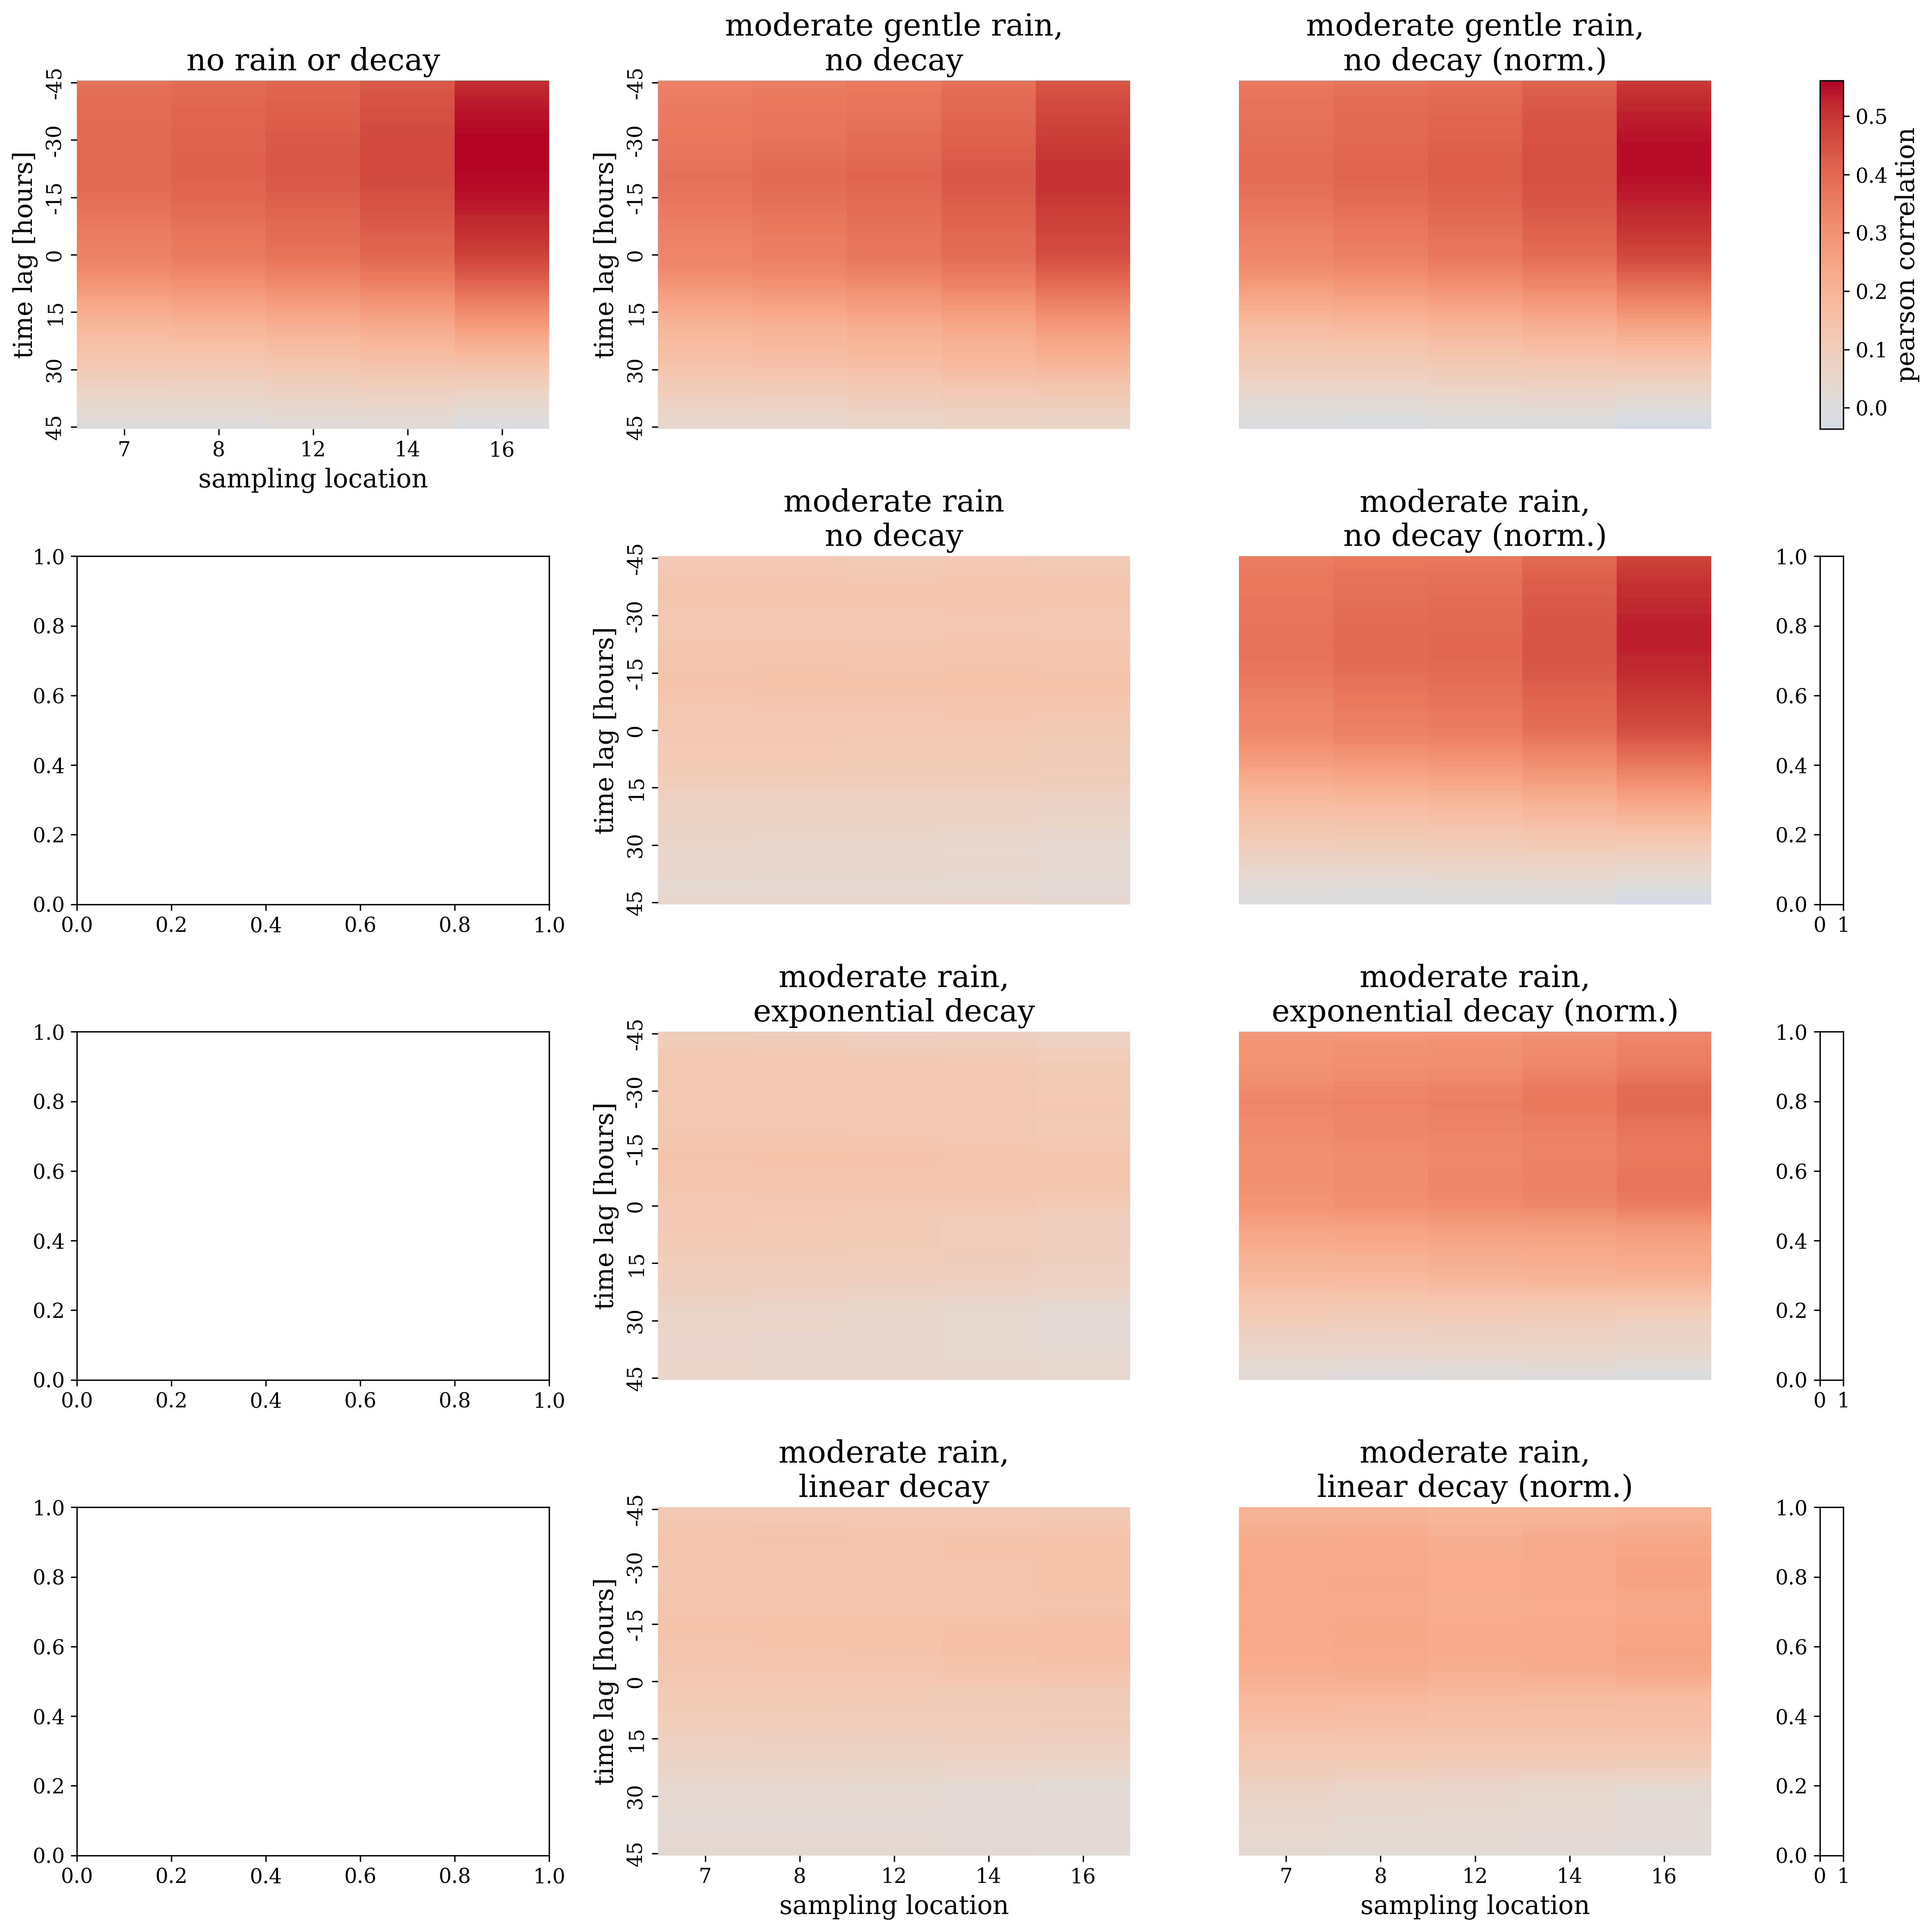

In [12]:
df_res_no_rain["rain_scenario"] = "no rain"
df_res_gentle_rain["rain_scenario"] = "gentle rain"
df_res_mod_rain["rain_scenario"] = "moderate rain"
df_res_gentle_rain_norm["rain_scenario"] = "gentle rain (norm)"
df_res_mod_rain_norm["rain_scenario"] = "moderate rain (norm)"
df_res_mod_rain_linear_decay["rain_scenario"] = "moderate rain, exponential decay"
df_res_mod_rain_linear_decay_norm["rain_scenario"] = "moderate rain, exponential decay (norm)"
df_res_mod_rain_constant_decay["rain_scenario"] = "moderate rain, linear decay"
df_res_mod_rain_constant_decay_norm["rain_scenario"] = "moderate rain, linear decay (norm)"
df = pd.concat([df_res_no_rain, df_res_gentle_rain, df_res_mod_rain, df_res_gentle_rain_norm, df_res_mod_rain_norm, df_res_mod_rain_linear_decay, df_res_mod_rain_linear_decay_norm, df_res_mod_rain_constant_decay, df_res_mod_rain_constant_decay_norm])

maxval = (df[['7', '8', '12', '14', '16']].max()).max()
minval = (df[['7', '8', '12', '14', '16']].min()).min()

fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (16,16), dpi=300, sharex=False, sharey=False, gridspec_kw=dict(width_ratios=[4,4,4,0.2])) 

sns.heatmap(data=df.loc[df.rain_scenario=="no rain",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=15, cbar = False, ax=axs[0,0], vmin = minval, vmax = maxval)
axs[0,0].set_title(f"no rain or decay")    
axs[0,0].set_xlabel(f"sampling location")
axs[0,0].set_ylabel(f"time lag [hours]")

sns.heatmap(data=df.loc[df.rain_scenario=="gentle rain",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=15, xticklabels=False, cbar = False, ax=axs[0,1], vmin = minval, vmax = maxval)
axs[0,1].set_title(f"moderate gentle rain,\nno decay")    
axs[0,1].set_xlabel(" ")
axs[0,1].set_ylabel(f"time lag [hours]")

sns.heatmap(data=df.loc[df.rain_scenario=="gentle rain (norm)",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=False, xticklabels=False, cbar=False, ax=axs[0,2], vmin = minval, vmax = maxval)
axs[0,2].set_title(f"moderate gentle rain,\nno decay (norm.)")    
axs[0,2].set_xlabel(" ")
axs[0,2].set_ylabel(" ")

sns.heatmap(data=df.loc[df.rain_scenario=="moderate rain",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=15, xticklabels=False, cbar = False, ax=axs[1,1], vmin = minval, vmax = maxval)
axs[1,1].set_title(f"moderate rain\nno decay")    
axs[1,1].set_xlabel(" ")
axs[1,1].set_ylabel(f"time lag [hours]")

sns.heatmap(data=df.loc[df.rain_scenario=="moderate rain (norm)",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=False, xticklabels=False, cbar=False, ax=axs[1,2], vmin = minval, vmax = maxval)  
axs[1,2].set_title(f"moderate rain,\nno decay (norm.)")    
axs[1,2].set_xlabel(" ")
axs[1,2].set_ylabel(" ")

sns.heatmap(data=df.loc[df.rain_scenario=="moderate rain, exponential decay",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=15, xticklabels=False, cbar = False, ax=axs[2,1], vmin = minval, vmax = maxval)
axs[2,1].set_title(f"moderate rain,\nexponential decay")    
axs[2,1].set_xlabel(" ")
axs[2,1].set_ylabel(f"time lag [hours]")

sns.heatmap(data=df.loc[df.rain_scenario=="moderate rain, exponential decay (norm)",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, xticklabels=False, yticklabels=False, cbar=False, ax=axs[2,2], vmin = minval, vmax = maxval)  
axs[2,2].set_title(f"moderate rain,\nexponential decay (norm.)")    
axs[2,2].set_xlabel(" ")
axs[2,2].set_ylabel(" ")

sns.heatmap(data=df.loc[df.rain_scenario=="moderate rain, linear decay",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=15, cbar = False, ax=axs[3,1], vmin = minval, vmax = maxval)
axs[3,1].set_title(f"moderate rain,\nlinear decay")    
axs[3,1].set_xlabel(f"sampling location")
axs[3,1].set_ylabel(f"time lag [hours]")

sns.heatmap(data=df.loc[df.rain_scenario=="moderate rain, linear decay (norm)",['7', '8', '12', '14', '16']], cmap='coolwarm', center=0, yticklabels=False, cbar=False, ax=axs[3,2], vmin = minval, vmax = maxval)  
axs[3,2].set_title(f"moderate rain,\nlinear decay (norm.)")    
axs[3,2].set_xlabel(f"sampling location")
axs[3,2].set_ylabel(" ")

fig.colorbar(axs[0,1].collections[0], cax=axs[0,3], label = "pearson correlation")

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"cross_correlations.png"), dpi=300)

In [23]:
df_res_no_rain["rain_scenario"] = "1. no rain"
df_res_no_rain["norm"] = "no"
df_res_gentle_rain["rain_scenario"] = "2. gentle rain"
df_res_gentle_rain["norm"] = "no"
df_res_mod_rain["rain_scenario"] = "3. moderate rain"
df_res_mod_rain["norm"] = "no"
df_res_gentle_rain_norm["rain_scenario"] = "2. gentle rain"
df_res_gentle_rain_norm["norm"] = "yes"
df_res_mod_rain_norm["rain_scenario"] = "3. moderate rain"
df_res_mod_rain_norm["norm"] = "yes"
df_res_mod_rain_linear_decay["rain_scenario"] = "4. moderate rain, exponential decay"
df_res_mod_rain_linear_decay["norm"] = "no"
df_res_mod_rain_linear_decay_norm["rain_scenario"] = "4. moderate rain, exponential decay"
df_res_mod_rain_linear_decay_norm["norm"] = "yes"
df_res_mod_rain_constant_decay["rain_scenario"] = "5. moderate rain, linear decay"
df_res_mod_rain_constant_decay["norm"] = "no"
df_res_mod_rain_constant_decay_norm["rain_scenario"] = "5. moderate rain, linear decay"
df_res_mod_rain_constant_decay_norm["norm"] = "yes"

df = pd.concat([df_res_no_rain, df_res_gentle_rain, df_res_mod_rain, df_res_gentle_rain_norm, df_res_mod_rain_norm, df_res_mod_rain_linear_decay, df_res_mod_rain_linear_decay_norm, df_res_mod_rain_constant_decay, df_res_mod_rain_constant_decay_norm])

max_corr = df.groupby(['rain_scenario', 'norm'])['16'].max().reset_index()
print(max_corr)

                         rain_scenario norm        16
0                           1. no rain   no  0.560807
1                       2. gentle rain   no  0.505772
2                       2. gentle rain  yes  0.549955
3                     3. moderate rain   no  0.152067
4                     3. moderate rain  yes  0.531371
5  4. moderate rain, exponential decay   no  0.139271
6  4. moderate rain, exponential decay  yes  0.399440
7       5. moderate rain, linear decay   no  0.161437
8       5. moderate rain, linear decay  yes  0.255418


/var/folders/h0/9nm34gsx7x1d6tknzfpscvsr0000gn/T/ipykernel_43555/4082692039.py:17: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='rain_scenario', y='16', data=max_corr, style = 'norm', hue = 'norm', markers = 'o', markersize=10)
/var/folders/h0/9nm34gsx7x1d6tknzfpscvsr0000gn/T/ipykernel_43555/4082692039.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


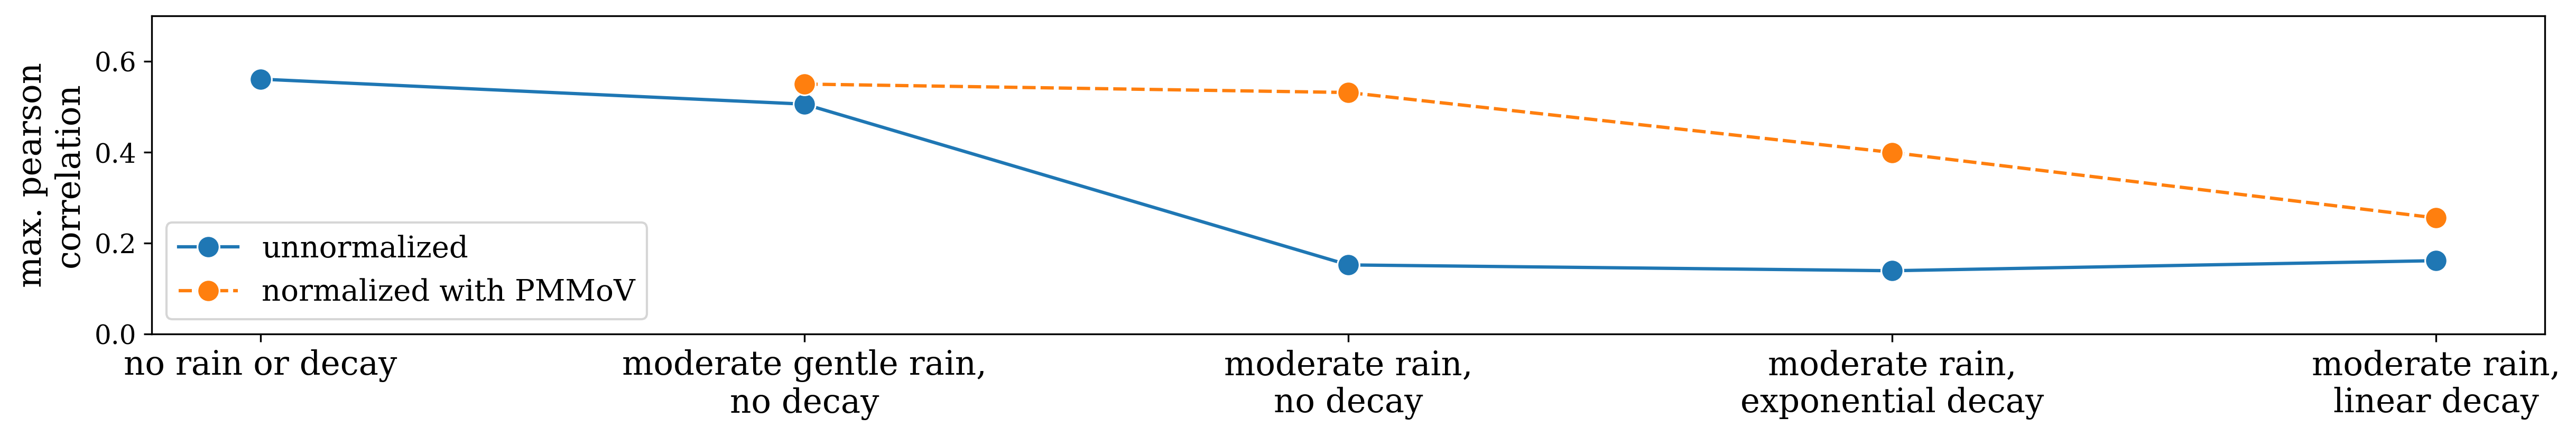

In [46]:
fig, ax = plt.subplots(figsize = (16.6,3), dpi=300) 
sns.lineplot(x='rain_scenario', y='16', data=max_corr, style = 'norm', hue = 'norm', markers = 'o', markersize=10)

ax.set_ylabel("max. pearson\ncorrelation")
ax.set_xlabel("")
ax.set_ylim(bottom = 0, top = 0.7)

new_labels = ['no rain or decay', 'moderate gentle rain,\nno decay', 'moderate rain,\nno decay', 'moderate rain,\nexponential decay', 'moderate rain,\nlinear decay']
ax.set_xticklabels(new_labels)

labels=["unnormalized","normalized with PMMoV"]
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="", loc = "lower left")

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"cross_correlations_simplified.png"), dpi=300)